# Image Preprocessing
We normalize the brightness values and resize the images to a standard shape

In [10]:
%matplotlib inline

import glob
import os
import re

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageOps

In [11]:
def natural_key(string_):
    """
    Define sort key that is integer-aware
    """
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

In [64]:
def norm_image(img):
    """
    Normalize PIL image
    
    Normalizes luminance to (mean,std)=(0,1), and applies a [1%, 99%] contrast stretch
    """
    img_y, img_b, img_r = img.convert('YCbCr').split()
    
    img_y_np = np.asarray(img_y).astype(float)

    img_y_np /= 255
    img_y_np -= img_y_np.mean()
    img_y_np /= img_y_np.std()
    scale = np.max([np.abs(np.percentile(img_y_np, 1.0)),
                    np.abs(np.percentile(img_y_np, 99.0))])
    img_y_np = img_y_np / scale
    img_y_np = np.clip(img_y_np, -1.0, 1.0)
    img_y_np = (img_y_np + 1.0) / 2.0
    
    img_y_np = (img_y_np * 255 + 0.5).astype(np.uint8)

    img_y = Image.fromarray(img_y_np)

    img_ybr = Image.merge('YCbCr', (img_y, img_b, img_r))
    
    img_nrm = img_ybr.convert('RGB')
    
    return img_nrm

In [19]:
def resize_image(img, size):
    """
    Resize PIL image
    
    Resizes image to be square with sidelength size. Pads with black if needed.
    """
    # Resize
    n_x, n_y = img.size
    if n_y > n_x:
        n_y_new = size
        n_x_new = int(size * n_x / n_y + 0.5)
    else:
        n_x_new = size
        n_y_new = int(size * n_y / n_x + 0.5)

    img_res = img.resize((n_x_new, n_y_new), resample=PIL.Image.BICUBIC)

    # Pad the borders to create a square image
    img_pad = Image.new('RGB', (size, size), (128, 128, 128))
    ulc = ((size - n_x_new) // 2, (size - n_y_new) // 2)
    img_pad.paste(img_res, ulc)

    return img_pad

In [20]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

train_cats = sorted(glob.glob(os.path.join(TRAIN_DIR, 'cat*.jpg')), key=natural_key)
train_dogs = sorted(glob.glob(os.path.join(TRAIN_DIR, 'dog*.jpg')), key=natural_key)
train_all = train_cats + train_dogs

test_all = sorted(glob.glob(os.path.join(TEST_DIR, '*.jpg')), key=natural_key)

24486


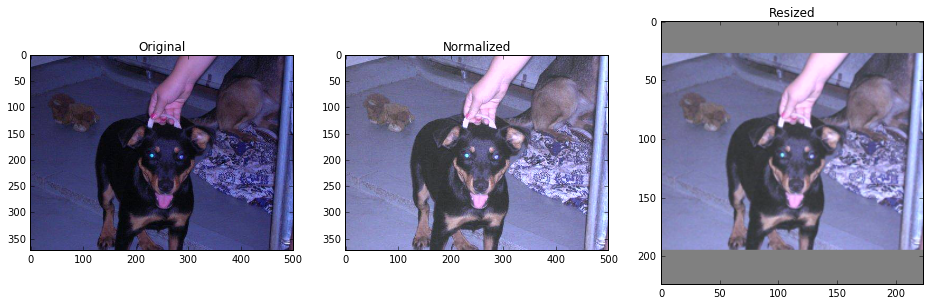

In [65]:
SIZE = 224  # for ImageNet models compatibility

# Read the image
# idx = np.random.randint(0, len(train_all))
idx = 24486
print(idx)
path = train_all[idx]
img = Image.open(path)

# Normalize it
img_nrm = norm_image(img)

# Resize it
img_res = resize_image(img_nrm, SIZE)

# Show it
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Original')
plt.imshow(img)

plt.subplot(132)
plt.title('Normalized')
plt.imshow(img_nrm)

plt.subplot(133)
plt.title('Resized')
plt.imshow(img_res)

plt.show()